In [1]:
import tensorflow as tf
import utils as u
import h5py
import itertools
import os
import numpy as np

from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import metrics

import keras 
from keras.models import load_model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D,Activation,BatchNormalization,LeakyReLU,UpSampling2D
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam


import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline

data_folder = '../../data'
file_name = 'HCAL_digi+rechit_occ.hdf5'
group = 'DigiTask_Occupancy_depth_depth1'

input_file=h5py.File(data_folder+"/"+file_name,'r+')

data_sample= np.array(input_file[group])


print data_sample.shape

data_sample=data_sample[:,:,26:58]

print data_sample.shape




input_images=data_sample[:]
hotregion_image=[]
deadregion_image=[]

for k in input_images:
    a=np.random.randint(input_images.shape[2]-5)
    b=np.random.randint(input_images.shape[1]-5)

    xdim=(a,a+5)
    ydim=(b,b+5)
   
    hotregion_image.append( u.hotregion(k,xdim,ydim))
    deadregion_image.append(u.killregion(k,xdim,ydim))
       
    
hotregion_image=np.array(hotregion_image)
deadregion_image=np.array(deadregion_image)

print "Shape of regular image is: ",input_images.shape
print "Shape of dead image is: " ,deadregion_image.shape
print "Shape of hot image is: " ,hotregion_image.shape

print ''

#im=plt.imshow(input_images[1],cmap=cm.coolwarm)
#plt.show()
#plt.clf()
#
#im=plt.imshow(hotregion_image[1],cmap=cm.coolwarm)
#plt.show()
#plt.clf()#plt.clf clears the figure and it's axis but leaves the window open. 
#         #as opposed to plt.close which closes the window. If you are showing many images at a time without
#         #closing the window it is better.
#
#im=plt.imshow(deadregion_image[1],cmap=cm.coolwarm)
#plt.show()
#plt.clf()
#input_image=np.reshape(input_image,(input_image.shape[0],input_image.shape[1]))




sample= np.append(data_sample,hotregion_image,axis=0)
sample= np.append(sample,deadregion_image,axis=0)


print sample.shape


X=np.copy(sample)

#y=np.zeros((sample.shape[0],1))

Using TensorFlow backend.


(999, 72, 84)
(999, 72, 32)
Shape of regular image is:  (999, 72, 32)
Shape of dead image is:  (999, 72, 32)
Shape of hot image is:  (999, 72, 32)

(2997, 72, 32)


X shape is:  (2997, 72, 32)
Xtrain.shape (700, 72, 32)
Xtest.shape (2297, 72, 32)
-------------------
[10]


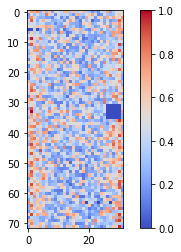

-------------------
[11]


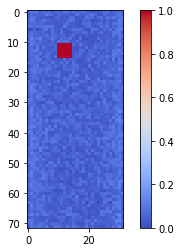

-------------------
[12]


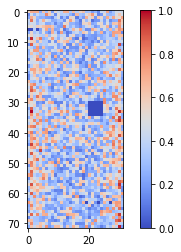

-------------------
[13]


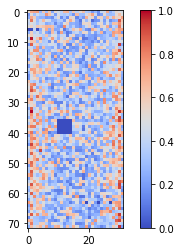

-------------------
[14]


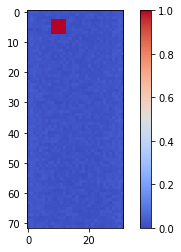

-------------------
[15]


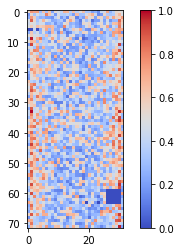

-------------------
[16]


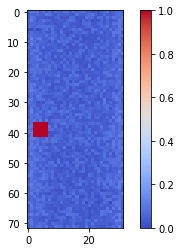

-------------------
[17]


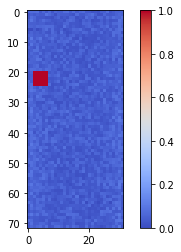

-------------------
[18]


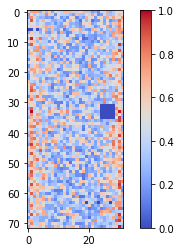

-------------------
[19]


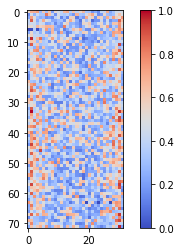

-------------------
[20]


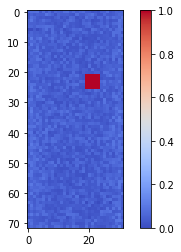

-------------------
[21]


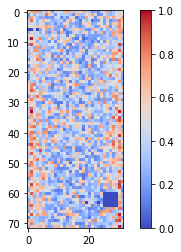

-------------------
[22]


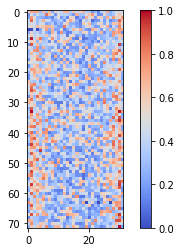

-------------------
[23]


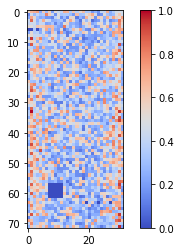

-------------------
[24]


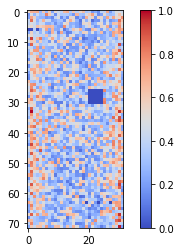

-------------------
[25]


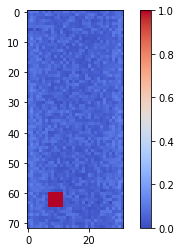

-------------------
[26]


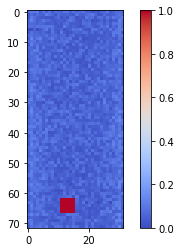

-------------------
[27]


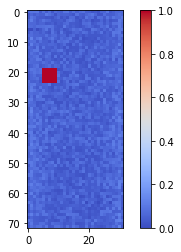

-------------------
[28]


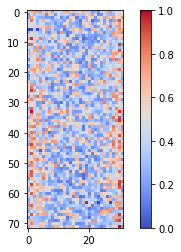

-------------------
[29]


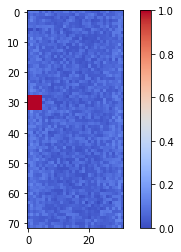

-------------------
[30]


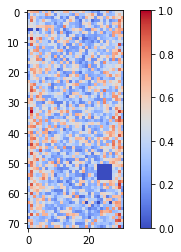

-------------------
[31]


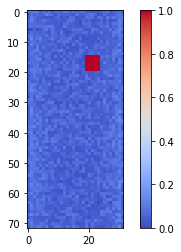

-------------------
[32]


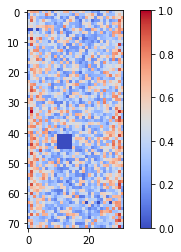

-------------------
[33]


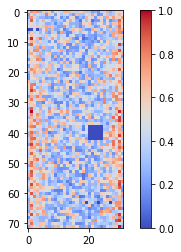

-------------------
[34]


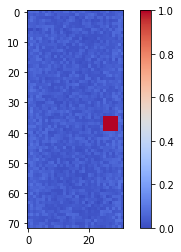

Xtrain.shape after if statement (700, 72, 32, 1)
Xtest.shape after if statement (2297, 72, 32, 1)
(72, 32, 1)


In [2]:

print "X shape is: ",X.shape
#print "y shape is: ",y.shape
# input image dimensions
img_rows, img_cols = X.shape[1],X.shape[2]
k=0
for img in X:
    X[k] = X[k] / np.max(img)
    k=k+1


#Xtrain, Xtest ,ytrain, ytest =train_test_split(X,X,test_size=.4,random_state =5 )
Xtrain= X[:700]
Xtest=X[700:]
Xtest=np.random.permutation(Xtest)


    

#Xtest = Xtest / np.max(Xtest)

print 'Xtrain.shape',Xtrain.shape
print 'Xtest.shape',Xtest.shape
#print 'ytrain.shape',ytrain.shape
#print 'ytest.shape',ytest.shape
#print 'Printing labels and their corresponding images'
    
for k in range(10,35):
    print'-------------------'
    print [k]
    im=plt.imshow(Xtest[k],cmap='coolwarm')
    plt.colorbar()
    plt.show()
    plt.clf()


Xtrain, Xtest,input_shape= u.check_test_and_train_images_format(Xtrain, Xtest, img_rows, img_cols)

print 'Xtrain.shape after if statement',Xtrain.shape
print 'Xtest.shape after if statement',Xtest.shape
#print 'ytrain.shape after if statement',ytrain.shape
print input_shape
#print 'ytest.shape after if statement',ytest.shape
    

In [3]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(input_shape))  # adapt this if using `channels_first` image data format

x = Conv2D(86, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(86, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

#autoencoder.compile(optimizer='rmsprop', loss='mean_squared_error')
autoencoder.save('empty_AE.hdf5')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 32, 86)        860       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 16, 86)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 16, 48)        37200     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 8, 48)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 8, 8)          3464      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 4, 8)           0         
__________

In [4]:
K.clear_session()


In [5]:
u.plot_loss(data=history,title="Loss vs Epoch",yscale='linear')

NameError: name 'history' is not defined

In [ ]:
best_model= load_model(filepath='AE_best_model.hdf5')

In [ ]:
pred=best_model.predict(Xtest)


In [ ]:
pred.shape

In [ ]:
for k in range(10,35):
    print'-------------------'
    print [k]
    im=plt.imshow(np.reshape(Xtest,(Xtest.shape[0],Xtest.shape[1],Xtest.shape[2]))[k],cmap=cm.coolwarm)
    plt.colorbar()
    plt.show()
    plt.clf()
    
    im=plt.imshow(np.reshape(pred,(pred.shape[0],pred.shape[1],pred.shape[2]))[k],cmap=cm.coolwarm)
    plt.colorbar()
    plt.show()
    plt.clf()
